## Project 5.2 Neural network multi-class classification - obesity type
Key things:  

Data taken from a **[kaggle competition](https://www.kaggle.com/competitions/playground-series-s4e2/overview)**

Non-obvious attributes:
* FAVC - Frequent consumption of high caloric food
* FCVC - Frequency of consumption of vegetables
* NCP - Number of main meals
* CAEC - Consumption of food between meals
* CH20 - Consumption of water daily
* CALC - Consumption of alcohol
* SCC - Calories consumption monitoring
* FAF - Physical activity frequency
* TUE - Time using technology devices
* MTRANS - (method of) Transportation used

(Target) Obesity scores/classes (NObesity) are:
* Underweight Less than 18.5
* Normal 18.5 to 24.9
* Overweight 25.0 to 29.9
* Obesity I 30.0 to 34.9
* Obesity II 35.0 to 39.9
* Obesity III Higher than 40

## Code setup

In [3]:
import pandas as pd
import numpy as np

# tf
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn utils
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

# sklearn preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# sklearn classification metrics
from sklearn.metrics  import (f1_score ,accuracy_score, confusion_matrix,
                            classification_report, ConfusionMatrixDisplay, 
                            roc_curve, precision_recall_curve,
                            auc, make_scorer, recall_score, accuracy_score, precision_score
                            )

from sklearn.ensemble import RandomForestClassifier

#### Datasets

In [64]:
# training dataset - to split into training and validationg
# df_path = '../datasets/obesity/train.csv' # -  original dataset with original columns names
df_path = '../datasets/obesity/train_renamed.csv'
df = pd.read_csv(df_path, index_col=0)

# testing dataset - unfortunately just the training dataset with no correct classes, but interesting
# nonetheless, to get the result you'd need to submit it to the project/competition page 
# test_df_path = '../datasets/obesity/test.csv' # -  original dataset with original columns names
test_df_path = '../datasets/obesity/test_renamed.csv'
test_df = pd.read_csv(test_df_path, index_col=0)

### Column renaming to human-readable - commented for notebook rerun ability
plus **nunique** explorations

one time operation, from now on we will be operating on datasets with these changes applied

By scheme of:
* family_history_with_overweight                   -> family_history
* FAVC - Frequent consumption of high caloric food -> high_caloric_cons
* FCVC - Frequency of consumption of vegetables    -> vegetable_freq
* NCP - Number of main meals                       -> main_meals
* CAEC - Consumption of food between meals         -> between_cons
* CH20 - Consumption of water daily                -> water_cons 
* CALC - Consumption of alcohol                    -> alcohol_cons
* SCC - Calories consumption monitoring            -> calorie_monitor
* FAF - Physical activity frequency                -> physical_freq
* TUE - Time using technology devices              -> device_time
* MTRANS - (method of) Transportation used         -> method_trans

Additionally, every column name will be uniformized to lowercase

In [55]:
# df.sample(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
18579,Female,19.673262,1.792378,151.417292,yes,yes,3.000000,3.0,Sometimes,no,2.837797,no,1.999897,0.727828,Sometimes,Public_Transportation,Obesity_Type_III
12143,Male,26.699317,1.789992,119.201465,yes,yes,2.195964,3.0,Sometimes,no,2.511399,no,0.691369,0.000000,Sometimes,Automobile,Obesity_Type_II
17910,Male,30.000000,1.780000,78.000000,yes,yes,1.000000,3.0,Frequently,no,2.000000,no,2.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
7667,Male,20.634694,1.699818,82.919584,yes,yes,1.936479,3.0,Sometimes,no,2.000000,no,0.835271,1.000000,Sometimes,Public_Transportation,Overweight_Level_II
1528,Male,18.000000,1.790000,108.000000,yes,yes,2.000000,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Obesity_Type_I


In [56]:
# df = df.rename(columns = {
#     'family_history_with_overweight': 'family_history',
#     'FAVC': 'high_caloric_cons',
#     'FCVC': 'vegetable_freq',
#     'NCP': 'main_meals',
#     'CAEC': 'between_meals_cons',
#     'CH2O': 'water_cons',
#     'CALC': 'alcohol_cons',
#     'SCC': 'calorie_monitor',
#     'FAF': 'physical_freq',
#     'TUE' : 'device_time',
#     'MTRANS': 'method_trans'
# })

In [57]:
# df.columns = [col.lower() for col in df.columns]

Let's also rename the target column name, from spanish to english

In [58]:
# df = df.rename(columns = {'nobeyesdad': 'obesity_class'})

In [59]:
# df.columns

Index(['gender', 'age', 'height', 'weight', 'family_history',
       'high_caloric_cons', 'vegetable_freq', 'main_meals',
       'between_meals_cons', 'smoke', 'water_cons', 'calorie_monitor',
       'physical_freq', 'device_time', 'alcohol_cons', 'method_trans',
       'obesity_class'],
      dtype='object')

#### Applying the column name transformations to the test dataset as well

In [60]:
# test_df = test_df.rename(columns = {
#     'family_history_with_overweight': 'family_history',
#     'FAVC': 'high_caloric_cons',
#     'FCVC': 'vegetable_freq',
#     'NCP': 'main_meals',
#     'CAEC': 'between_meals_cons',
#     'CH2O': 'water_cons',
#     'CALC': 'alcohol_cons',
#     'SCC': 'calorie_monitor',
#     'FAF': 'physical_freq',
#     'TUE' : 'device_time',
#     'MTRANS': 'method_trans'
# })

In [61]:
# test_df.columns = [col.lower() for col in test_df.columns]

In [62]:
# test_df.columns

Index(['gender', 'age', 'height', 'weight', 'family_history',
       'high_caloric_cons', 'vegetable_freq', 'main_meals',
       'between_meals_cons', 'smoke', 'water_cons', 'calorie_monitor',
       'physical_freq', 'device_time', 'alcohol_cons', 'method_trans'],
      dtype='object')

#### Saving the dataframes with new columns names

In [63]:
df.to_csv('../datasets/obesity/train_renamed.csv')
test_df.to_csv('../datasets/obesity/test_renamed.csv')

In [14]:
df.nunique()

Gender                               2
Age                               1703
Height                            1833
Weight                            1979
family_history_with_overweight       2
FAVC                                 2
FCVC                               934
NCP                                689
CAEC                                 4
SMOKE                                2
CH2O                              1506
SCC                                  2
FAF                               1360
TUE                               1297
CALC                                 3
MTRANS                               5
NObeyesdad                           7
dtype: int64

#### Further nunique explorations

It seems there are many binary columns (2 unique values) - we'll be changing that. But also - what is happening with the age column? 1703 unique values? Surely that's not possible. Let's examine that.

In [15]:
df['Age']

id
0        24.443011
1        18.000000
2        18.000000
3        20.952737
4        31.641081
           ...    
20753    25.137087
20754    18.000000
20755    20.101026
20756    33.852953
20757    26.680376
Name: Age, Length: 20758, dtype: float64

Ah, it seems the ages, generated for the dataset were either allowed to be float values, or they were taken from the exact date of birth - doubtly necessary.

Let's look at the other columns of high uniqueness of values

In [16]:
df['Height']

id
0        1.699998
1        1.560000
2        1.711460
3        1.710730
4        1.914186
           ...   
20753    1.766626
20754    1.710000
20755    1.819557
20756    1.700000
20757    1.816547
Name: Height, Length: 20758, dtype: float64

The data is presented in meters - we really need such precision or should rounding to the second decimal place be enough? To improve model generality and learning, a rounding approach will be taken

In [17]:
df['Weight']

id
0         81.669950
1         57.000000
2         50.165754
3        131.274851
4         93.798055
            ...    
20753    114.187096
20754     50.000000
20755    105.580491
20756     83.520113
20757    118.134898
Name: Weight, Length: 20758, dtype: float64

## EDA

#### Head, dtypes, describe, info

In [67]:
df.head()

,gender,age,height,weight,family_history,high_caloric_cons,vegetable_freq,main_meals,between_meals_cons,smoke,water_cons,calorie_monitor,physical_freq,device_time,alcohol_cons,method_trans,obesity_class
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [68]:
df.dtypes

gender                 object
age                   float64
height                float64
weight                float64
family_history         object
high_caloric_cons      object
vegetable_freq        float64
main_meals            float64
between_meals_cons     object
smoke                  object
water_cons            float64
calorie_monitor        object
physical_freq         float64
device_time           float64
alcohol_cons           object
method_trans           object
obesity_class          object
dtype: object

In [69]:
df.describe()

,age,height,weight,vegetable_freq,main_meals,water_cons,physical_freq,device_time
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


The metrics are obviously only being shown for numerical columns

#### Nulls, nuniques

In [70]:
df.isnull().sum()

gender                0
age                   0
height                0
weight                0
family_history        0
high_caloric_cons     0
vegetable_freq        0
main_meals            0
between_meals_cons    0
smoke                 0
water_cons            0
calorie_monitor       0
physical_freq         0
device_time           0
alcohol_cons          0
method_trans          0
obesity_class         0
dtype: int64

No nulls, beautiful

In [71]:
df.nunique()

gender                   2
age                   1703
height                1833
weight                1979
family_history           2
high_caloric_cons        2
vegetable_freq         934
main_meals             689
between_meals_cons       4
smoke                    2
water_cons            1506
calorie_monitor          2
physical_freq         1360
device_time           1297
alcohol_cons             3
method_trans             5
obesity_class            7
dtype: int64

### Data transformations
All in all, the data will be transformed in the following ways:
* The column names will be changed to be more human-readable, whilst maintaining conciseness
* Age and other columns (above) values will be discretized (rounded) - age to integer, the rest to the second decimal place
* columns of type object, if binary or categorical, will be encoded either one-hot, cardinally or whatever's needed

Columns to round to 2:
* height
* weight
* vegetable_freq 
* main_meals
* water_cons
* physical_freq
* device_time

### Rounding, scaling, encoding - new dataset variable - df_eng

In [72]:
df_eng = df.copy()

#### Scaling

In [73]:
df_eng['age'] = round(df_eng['age'],0).astype('int')

In [77]:
df_eng.columns

Index(['gender', 'age', 'height', 'weight', 'family_history',
       'high_caloric_cons', 'vegetable_freq', 'main_meals',
       'between_meals_cons', 'smoke', 'water_cons', 'calorie_monitor',
       'physical_freq', 'device_time', 'alcohol_cons', 'method_trans',
       'obesity_class'],
      dtype='object')

In [78]:
to_round_cols = ['height', 'weight', 'vegetable_freq',
                 'main_meals', 'water_cons', 'physical_freq',
                 'device_time']

In [79]:
df_eng[to_round_cols] = round(df_eng[to_round_cols],2)

In [84]:
df_eng['weight'] = round(df['weight'],1)

Let's check the unique values count now

In [85]:
df_eng.nunique()

gender                  2
age                    42
height                 51
weight                718
family_history          2
high_caloric_cons       2
vegetable_freq        190
main_meals            252
between_meals_cons      4
smoke                   2
water_cons            200
calorie_monitor         2
physical_freq         266
device_time           195
alcohol_cons            3
method_trans            5
obesity_class           7
dtype: int64

Much more manageable

#### Encoding

In [86]:
df_eng.sample(5)

,gender,age,height,weight,family_history,high_caloric_cons,vegetable_freq,main_meals,between_meals_cons,smoke,water_cons,calorie_monitor,physical_freq,device_time,alcohol_cons,method_trans,obesity_class
id,,,,,,,,,,,,,,,,,
6010,Male,21,1.72,104.9,yes,yes,2.00,1.92,Sometimes,no,1.85,no,0.0,1.41,no,Public_Transportation,Obesity_Type_II
9049,Male,23,1.75,95.3,yes,yes,2.00,3.00,Sometimes,no,2.08,no,2.0,1.40,no,Public_Transportation,Obesity_Type_I
13216,Male,23,1.87,121.7,yes,yes,2.72,2.99,Sometimes,no,1.57,no,0.9,0.00,Sometimes,Public_Transportation,Obesity_Type_II
12900,Female,18,1.55,56.0,no,yes,3.00,3.00,Frequently,no,2.00,no,1.0,1.00,Sometimes,Public_Transportation,Normal_Weight
15942,Female,23,1.60,84.0,yes,yes,2.00,3.00,Sometimes,no,2.00,no,2.0,0.00,Sometimes,Public_Transportation,Obesity_Type_I


##### Yes/no to binary

In [87]:
yesno_cols = ['family_history', 'high_caloric_cons', 'smoke', 'calorie_monitor']

In [88]:
for col in yesno_cols:
    df_eng[col] = df_eng[col].replace({'yes': 1, 'no': 0})

C:\Users\User\AppData\Local\Temp\ipykernel_22724\293709219.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eng[col] = df_eng[col].replace({'yes': 1, 'no': 0})


##### One hot

In [91]:
one_hot_cols = ['gender', 'method_trans']

In [92]:
df_eng = pd.get_dummies(df_eng, columns = one_hot_cols)

##### cardinal columns

In [94]:
df_eng['between_meals_cons'].unique()

array(['Sometimes', 'Frequently', 'no', 'Always'], dtype=object)

In [95]:
df_eng['alcohol_cons'].unique()

array(['Sometimes', 'no', 'Frequently'], dtype=object)

In [96]:
df_eng['between_meals_cons'] = df_eng['between_meals_cons'].map(
    {
        'no': 0,
        'Sometimes': 1,
        'Frequently': 2,
        'Always': 3
    }
)

In [97]:
df_eng['alcohol_cons'] = df_eng['alcohol_cons'].map(
    {
        'no': 0,
        'Sometimes': 1,
        'Frequently': 2
    }
)

##### The result

In [98]:
df_eng.sample(5)

,age,height,weight,family_history,high_caloric_cons,vegetable_freq,main_meals,between_meals_cons,smoke,water_cons,...,device_time,alcohol_cons,obesity_class,gender_Female,gender_Male,method_trans_Automobile,method_trans_Bike,method_trans_Motorbike,method_trans_Public_Transportation,method_trans_Walking
id,,,,,,,,,,,,,,,,,,,,,
19494,23,1.74,96.4,1,1,2.0,2.98,1,0,2.77,...,2.00,0,Obesity_Type_I,False,True,False,False,False,True,False
20578,20,1.75,75.0,0,0,3.0,3.00,2,1,1.00,...,0.00,1,Normal_Weight,False,True,False,False,False,True,False
20209,22,1.75,75.0,1,1,2.0,3.00,2,0,1.00,...,2.00,1,Overweight_Level_I,True,False,False,False,False,True,False
15950,26,1.65,104.8,1,1,3.0,3.00,1,0,2.84,...,0.12,1,Obesity_Type_III,True,False,False,False,False,True,False
18814,55,1.67,80.0,1,1,2.0,3.00,1,0,2.00,...,0.00,0,Overweight_Level_II,False,True,True,False,False,False,False


In [99]:
df_eng.dtypes

age                                     int32
height                                float64
weight                                float64
family_history                          int64
high_caloric_cons                       int64
vegetable_freq                        float64
main_meals                            float64
between_meals_cons                      int64
smoke                                   int64
water_cons                            float64
calorie_monitor                         int64
physical_freq                         float64
device_time                           float64
alcohol_cons                            int64
obesity_class                          object
gender_Female                            bool
gender_Male                              bool
method_trans_Automobile                  bool
method_trans_Bike                        bool
method_trans_Motorbike                   bool
method_trans_Public_Transportation       bool
method_trans_Walking              

#### Saving the encoded format to new dataframe file

In [102]:
df_eng.to_csv('../datasets/obesity/train_encoded.csv')

### Data distributions

In [100]:
df_eng['obesity_class'].value_counts()

obesity_class
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

In [101]:
cols = df_eng.columns

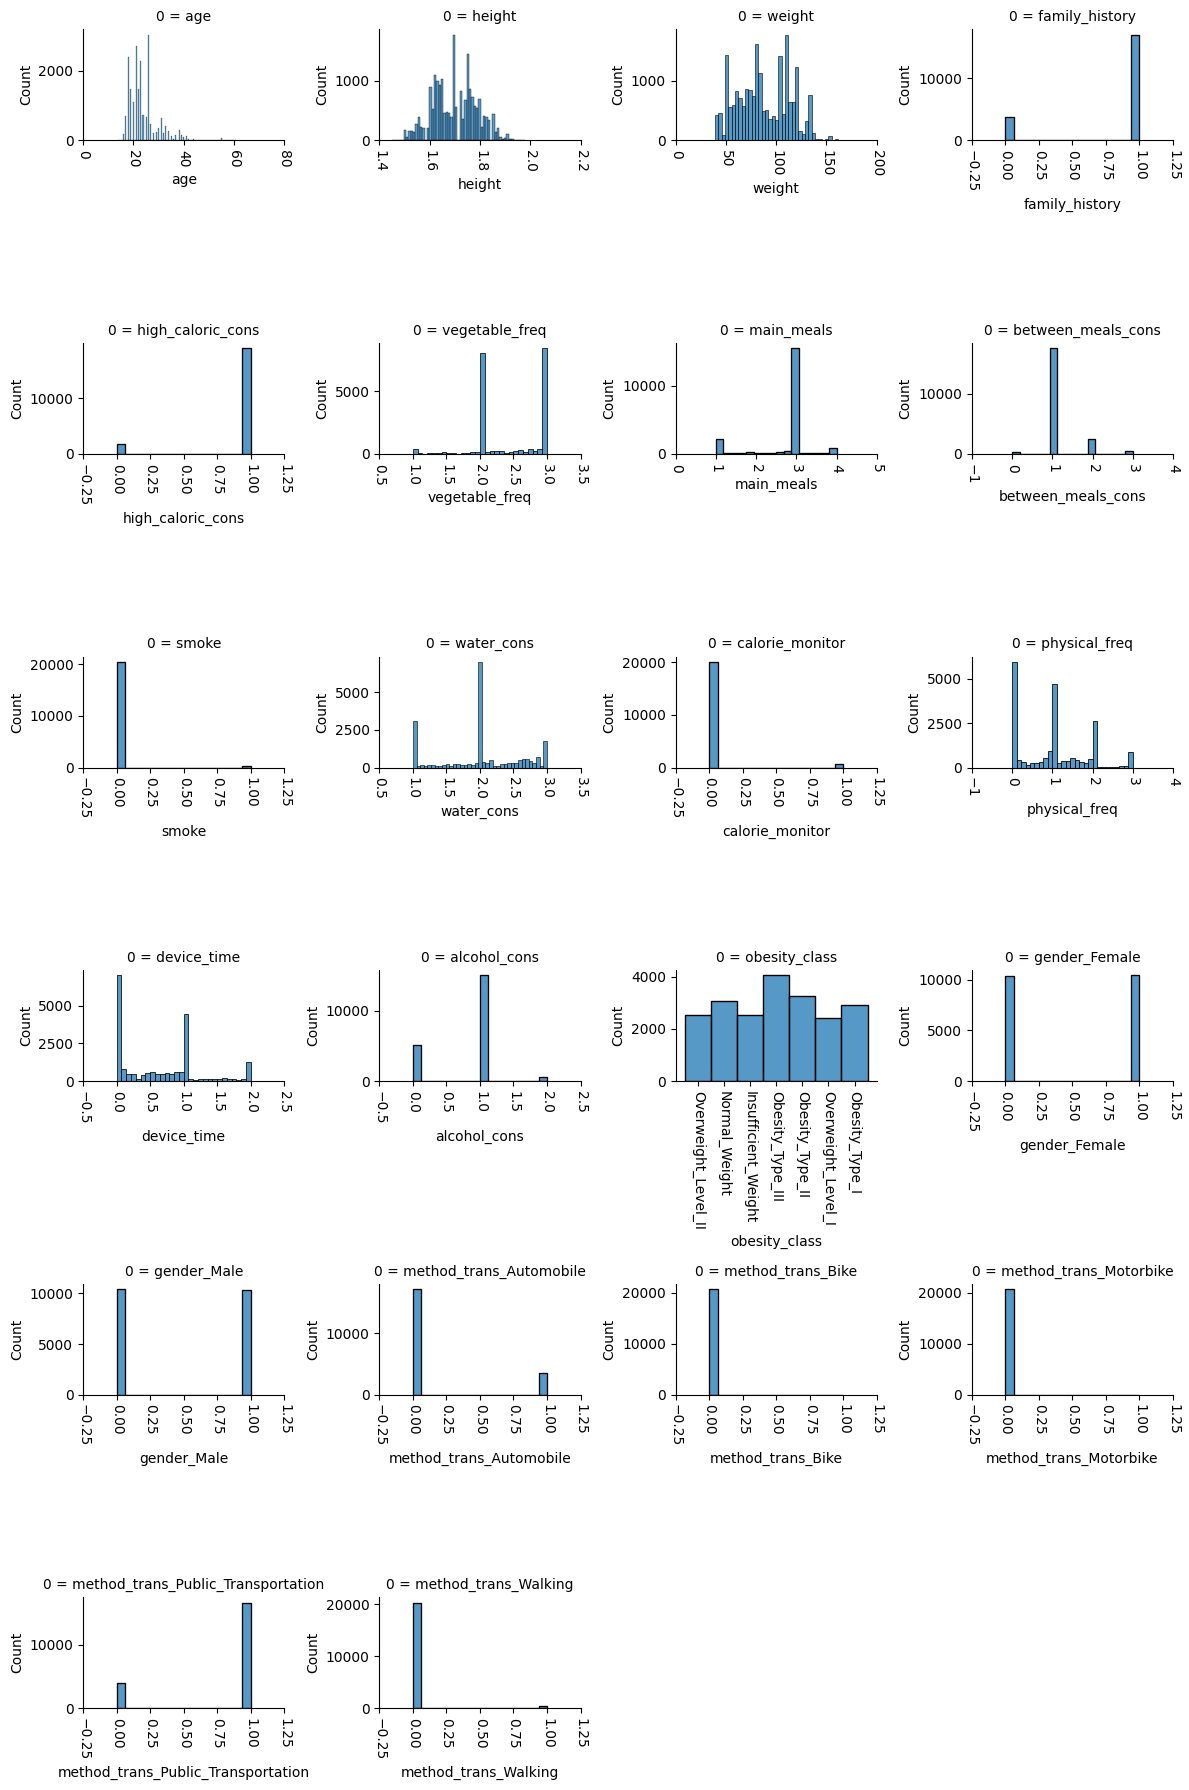

In [103]:
g = sns.FacetGrid(pd.DataFrame(list(cols)), col=0, col_wrap=4, sharex=False, sharey=False)
for ax, col in zip(g.axes, list(cols)):
    sns.histplot(df_eng[col], ax=ax)
g.set_xticklabels(rotation=-90)
g.tight_layout()

### TODO: df_eng and something about distributions within obsesity classes